<a href="https://colab.research.google.com/github/Jayesh1211/PASQAL_HACK/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


* **GCN Overview**: Extends traditional neural networks to graph-structured data, enabling learning from node relationships through message passing.

* **Graph Representation**:
 * *Nodes*: Molecular species,
 * *Edges*: Competing reaction pathways,
 * *Edge Weights*: Represent reaction attributes.

* **GCN Utility**: Predicting reaction feasibility, learning molecular transformations from existing data
* **Application**: Used synthetic data to classify desirable vs. undesirable nodes in the reaction graph.


In [ ]:
# Import the NetworkX package
import networkx as nx
import numpy as np
import math

In [ ]:
#
import torch
print("PyTorch has version {}".format(torch.__version__))

In [ ]:
# Install torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

**Data Preparation**

**Graph Generation:**

* The reaction pathway is represented as a graph, where:

 * *Nodes* represent molecular species (e.g., CO₂, HCOO, CH₃OH).

 * *Edges* represent transitions between species (e.g., CO₂ → HCOO).

 * *Edge Weights* are computed using the Arrhenius equation:

    $$ w_{ij} = e^{-E_a/RT} $$
  * where $ E_a $ is the activation energy, R is the gas constant, and
T is the temperature.

* Graphs are generated for different temperatures (e.g., 250K, 275K, 300K, etc.).

* Node Features: Each node is assigned a one-hot encoded feature vector (x = torch.eye(7)), where 7 is the number of nodes (molecular species).

* Edge Features: Edge weights are normalized transition probabilities, computed from activation energies and temperature.

* Labels: Nodes are labeled as 1 (useful) or 0 (not useful) based on whether they contribute to the desired product (CH₃OH) or are byproducts (e.g., CO, CH₄).

In [62]:

nodes = [0, 1, 2, 3, 4, 5, 6]

Ea = { (0,1): 50, (1,2): 45, (2,3): 40, (3,4): 35, (1,5): 60, (2,6): 55 }  # Activation energies in kJ/mol

next_state_set = {
    0: [1],        # CO2 → HCOO
    1: [2, 5],     # HCOO → HCO (desired) or  HCOO → CO (undesired)
    2: [3, 6],     # HCO → CH3O (desired) or  HCO → CH4 (competing)
    3: [4],        # CH3O → CH3OH
    4: [],         # Desired product (CH3OH)
    5: [],         # Undesired byproduct (CO)
    6: []          # Undesired byproduct (CH4)
    }

T = 300  # Temperature in Kelvin

weights = {}
for (s, s_next), ea in Ea.items():
    weights[(s, s_next)] = np.exp(-ea * 1000 / (8.314 * T))

# Normalize transition probabilities per state
for s in nodes:
    if s in next_state_set:
        total = sum(weights.get((s, s_next), 0) for s_next in next_state_set[s])
        if total > 0:
            for s_next in next_state_set[s]:
                weights[(s, s_next)] /= total

A = []
for (i,j),val in Ea.items():
    #print(i,j,"  ",val,"   ",weights[(i,j)])
    A.append(val)


#print(weights)

In [ ]:
## Setup for data visualisation
# Define labels for the molecules
node_labels = {
    0: "CO2",
    1: "HCOO",
    2: "HCO",
    3: "CH3O",
    4: "CH3OH",  # Desired product
    5: "CO",  # Byproduct
    6: "CH4"  # Byproduct
    }

pos = { ## Position of graph/ MDP nodes in the visualization
        0: (0, 0),
        1: (2, 0),
        2: (4, 0),
        3: (6, 0),
        4: (8, 0),
        5: (2.5, 0.5),
        6: (2.5, -0.5)
    }

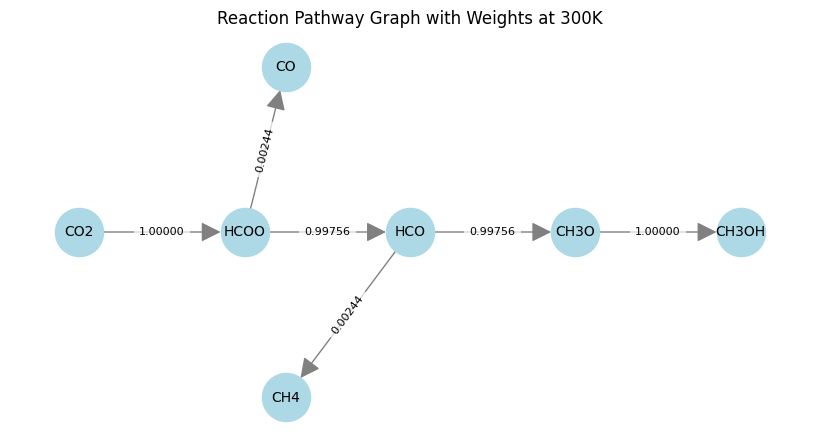

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for (u, v), weight in weights.items():
    G.add_edge(u, v, weight=weight)

# Draw the graph
#pos = nx.spring_layout(G, seed=42)  # Layout for visualization

labels = {edge: f'{data["weight"]:.5f}' for edge, data in G.edges.items()}
import networkx as nx
import matplotlib.pyplot as plt
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for (u, v), weight in weights.items():
    G.add_edge(u, v, weight=weight)

# Draw the graph
labels = {edge: f'{data["weight"]:.5f}' for edge, data in G.edges.items()}

plt.figure(figsize=(8, 4))
nx.draw(G,labels=node_labels, pos=pos, node_size=1200, node_color='lightblue', edge_color='gray', font_size=10,arrowsize=30)
nx.draw_networkx_edge_labels(G, pos, font_size=8, bbox=dict(facecolor="white", edgecolor="none", alpha=0.7), edge_labels=labels)
plt.title("Reaction Pathway Graph with Weights at 300K")
plt.show()
plt.show()

In [ ]:
## To generates edge weights at different Temperatures

def generate_graph(T):

  kinetic_data = {
        (0, 1): 50,    # CO2 → HCOO (Desired)
        (1, 2): 45,    # HCOO → HCO (Desired)
        (2, 3): 40,    # HCO → CH3O (Desired)
        (3, 4): 35,    # CH3O → CH3OH (Desired)
        (1, 5): 60,    # HCOO → CO (Competing)
        (2, 6): 55,    # HCO → CH4 (Competing)
    }

  edge_index = torch.tensor(list(kinetic_data.keys()), dtype=torch.long).t()
  #Ea = { (0,1): 50, (1,2): 45, (2,3): 40, (3,4): 35, (1,5): 60, (2,6): 55 }  # Activation energies in kJ/mol

  next_state_set = {
      0: [1],        # CO2 → HCOO
      1: [2, 5],     # HCOO → HCO (desired) or  HCOO → CO (undesired)
      2: [3, 6],     # HCO → CH3O (desired) or  HCO → CH4 (competing)
      3: [4],        # CH3O → CH3OH
      4: [],         # Desired product (CH3OH)
      5: [],         # Undesired byproduct (CO)
      6: []          # Undesired byproduct (CH4)
      }

  #T = 300  # Temperature in Kelvin

  weights = {}
  for (s, s_next), ea in kinetic_data.items():
      weights[(s, s_next)] = np.exp(-ea * 1000 / (8.314 * T))

  # Normalize transition probabilities per state
  for s in nodes:
      if s in next_state_set:
          total = sum(weights.get((s, s_next), 0) for s_next in next_state_set[s])
          if total > 0:
              for s_next in next_state_set[s]:
                  weights[(s, s_next)] /= total
  #print(weights)
  A = []
  for (i,j),val in Ea.items():
    #print(i,j,"  ",val,"   ",weights[(i,j)])
    A.append(val)
  edge_attr = torch.tensor(A, dtype=torch.float)

  y = torch.tensor([1, 1, 1, 1, 1, 0, 0], dtype=torch.long)  # Useful (1) vs Not Useful (0)
  x = torch.eye(7)  # Dummy identity matrix as node features
  #print(weights)
  return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

 **Model Architecture**

The GCN model consists of:

* *Input Layer*: Takes node features (7-dimensional one-hot vectors).

* *Hidden Layer*: A GCN layer with 4 hidden units and ReLU activation.

* *Output Layer*: A GCN layer with 2 output units (for binary classification).

* *Softmax Activation*: Applied to the output to obtain probabilities for each class.

**Training Process**

* *Optimizer*: Adam optimizer with a learning rate of 0.01 and weight decay of $5 * 10^{-4}$.

* *Loss Function*: Cross-entropy loss is used to measure the difference between predicted and true labels.

* *Training Loop*:

 * The model is trained for 400 epochs.

 * For each epoch, the model processes the dataset in batches.

 * The loss is computed, and backpropagation is performed to update the model parameters.

* Softmax probabilities are computed and stored for analysis.

**Validation and Evaluation**

* Validation: The model is evaluated on a test dataset generated at
$T = 300K$.

* Metrics:

 * Classification Accuracy: The percentage of correctly classified nodes (useful vs. not useful).

 * Softmax Probabilities: Provide insights into the model's confidence in its predictions.

In [81]:


# Generate multiple graphs for different temperatures
temperatures = [225,250, 275, 325, 350, 375,400,425,450]
dataset = [generate_graph(T) for T in temperatures]
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        #logi = x.detach().cpu().numpy().round(F.softmax(x, dim=1),4)
        #print(x, F.softmax(x, dim=1))
        return F.softmax(x, dim=1)

# Initialize Model & Optimizer
model = GCN(input_dim=7, hidden_dim=4, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


loss_list = []
softmax_values_per_epoch = []
n = 400
# Train GCN on multiple graphs
for epoch in range(n):
    model.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr)
        # Calculate softmax probabilities
        softmax_probs = F.softmax(out, dim=1).detach().cpu().numpy()  # Move to CPU and convert to NumPy

        # Append softmax values for the current epoch
        softmax_values_per_epoch.append(softmax_probs)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_list.append(total_loss)
    if epoch % 30 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss:.4f}')

# Evaluate on a new temperature graph
T_test = 300
test_data = generate_graph(T_test)
model.eval()
pred = model(test_data.x, test_data.edge_index, test_data.edge_attr).argmax(dim=1)


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Loss: 6.8602
Epoch 30, Loss: 4.5164
Epoch 60, Loss: 4.2985
Epoch 90, Loss: 4.1019
Epoch 120, Loss: 3.9307
Epoch 150, Loss: 3.7919
Epoch 180, Loss: 3.6853
Epoch 210, Loss: 3.6072
Epoch 240, Loss: 3.5524
Epoch 270, Loss: 3.5157
Epoch 300, Loss: 3.4924
Epoch 330, Loss: 3.4787
Epoch 360, Loss: 3.4717
Epoch 390, Loss: 3.4678


For a test temperature of
$T=300 K$, the model predicts the label shown below:

In [82]:
print(f'Predicted Labels for T={T_test}: {pred.tolist()}')

Predicted Labels for T=300: [1, 1, 1, 1, 1, 0, 0]




This indicates that nodes 0 to 4 (CO₂, HCOO, HCO, CH₃O, CH₃OH) are classified as useful, while nodes 5 and 6 (CO, CH₄) are classified as not useful.

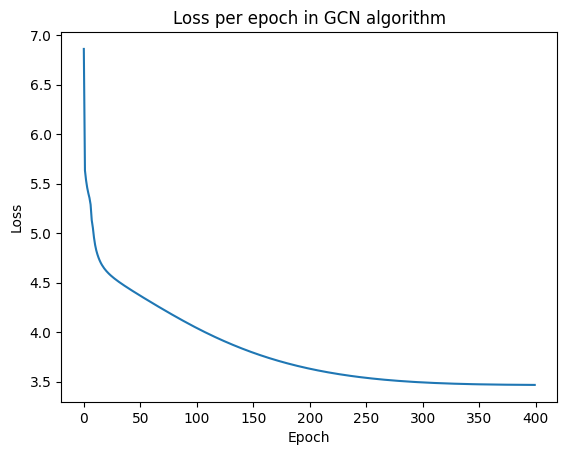

In [83]:
# 6. Visualize the loss fucntion for each epoch for GCN algorithm
x = np.arange(n)  # X-axis points
plt.plot(x, loss_list)  # Plot the chart
plt.title("Loss per epoch in GCN algorithm")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

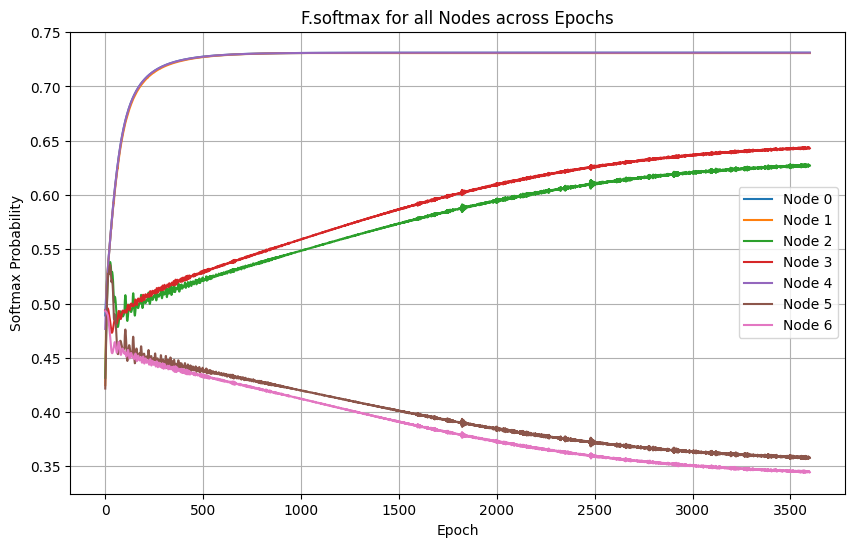

In [76]:
## To confirm that the GCN model learnt the parameters :
#  Plot softmax values for node 0 across all epochs
plt.figure(figsize=(10, 6))
for node_index in range(7):  # Assuming 7 nodes
    node_softmax_values = [softmax[node_index, 1] for softmax in softmax_values_per_epoch] # probability of class 1
    plt.plot(node_softmax_values, label=f"Node {node_index}")

plt.xlabel("Epoch")
plt.ylabel("Softmax Probability")
plt.title("F.softmax for all Nodes across Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [77]:
# To visualize the solution
def visualize_graph(G, pred, pos, node_labels):
    """Visualize the graph with node coloring based on predicted labels, following the given reference style."""

    plt.figure(figsize=(8, 5))

    # Determine node colors based on predicted labels
    node_colors = []
    for n in G.nodes():
        if pred[n] == 1:  # Selected node
            node_colors.append('darkblue')
        else:  # Unselected node
            node_colors.append('red')

    # Draw nodes with appropriate colors
    nx.draw_networkx_nodes(G, pos, node_size=[1200 if pred[n] == 1 else 1000 for n in G.nodes],
                           node_color=node_colors, alpha=0.8)

    # Draw edges
    selected_edges = [(i, j) for i, j in G.edges() if pred[i] == 1 and pred[j] == 1]
    other_edges = [(i, j) for i, j in G.edges() if (i, j) not in selected_edges]

    if selected_edges:
        nx.draw_networkx_edges(G, pos, edgelist=selected_edges, width=3.0, edge_color='green', style='solid')

    nx.draw_networkx_edges(G, pos, edgelist=other_edges, width=1.5, edge_color='red', style='dashed', alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold', font_color="white")

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='darkblue', markersize=10, linestyle='', label='Selected Node'),
        plt.Line2D([0], [0], marker='o', color='red', markersize=10, linestyle='', label='Unselected Node'),
        plt.Line2D([0], [0], color='green', lw=3, label='Selected Edge'),
        plt.Line2D([0], [0], color='red', lw=1.5, linestyle='dashed', label='Unselected Edge')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

    plt.title("Graph Visualization with predicted labels using GCN", fontsize=20)
    #plt.axis('off')
    plt.tight_layout()

    #return plt.gcf()

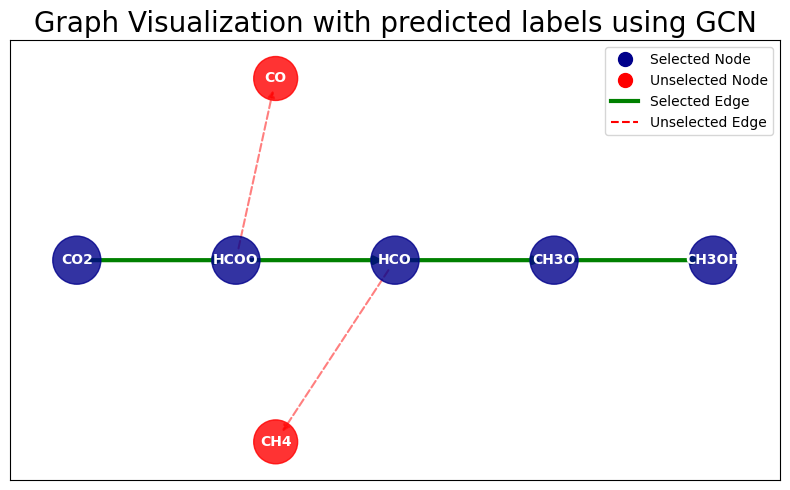

In [78]:
# 7. Visualize Graph
# Call the function to visualize
visualize_graph(G, pred,pos,node_labels)

In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on the test data
def evaluate_model(model, test_data):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Get predictions
        out = model(test_data.x, test_data.edge_index, test_data.edge_attr)
        pred = out.argmax(dim=1)  # Get the predicted class labels

        # Convert predictions and true labels to numpy arrays
        pred_labels = pred.cpu().numpy()
        true_labels = test_data.y.cpu().numpy()

        # Compute evaluation metrics
        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels)
        recall = recall_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels)

        return accuracy, precision, recall, f1

# Evaluate the model on the test dataset
T_test = 300
test_data = generate_graph(T_test)
accuracy, precision, recall, f1 = evaluate_model(model, test_data)

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


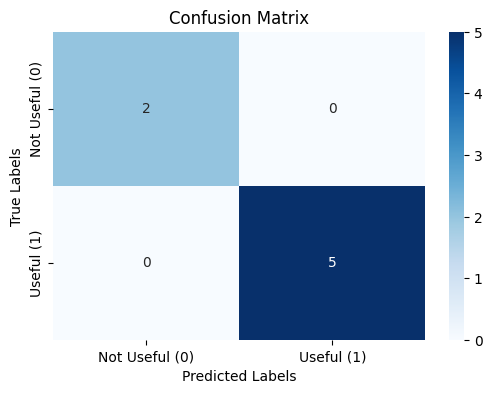

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
true_labels = [1,1,1,1,1,0,0]
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred)

# Visualize confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Useful (0)", "Useful (1)"],
            yticklabels=["Not Useful (0)", "Useful (1)"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

**Key Takeaways**

* The GCN is trained on a dataset of reaction pathways at different temperatures.

* It classifies nodes as useful or not useful based on their contribution to methanol production.

* The model provides insights into reaction feasibility and optimal conditions for maximizing yield.